**Задача:**

Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных
- Выделите портреты клиентов, которые склонны уходить из банка
- Сформулируйте и проверьте статистические гипотезы

**Описание датасета**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


**Выводы:**
- Типы данных корректны
- Присутствуют многочисленные пропуски в колонке `Balance`

## Предобработка данных

In [3]:
# Приведем названия колонок к нижнему регистру

df.columns = map(str.lower, df.columns)

# Подсчитаем количество явных дубликатов

df.duplicated().sum()

0

In [4]:
# Подсчитаем количество дубликатов в колонке 'userid'

df['userid'].duplicated().sum()

0

In [5]:
# Проверка на наличие неявных дубликатов в колонке 'city'

df['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

Проверим, отличаются ли средние значения у клиентов с пропусками в колонке `balance` от всех остальных

In [6]:
df.drop(columns=['userid'])[df['balance'].isna()].mean()

score                 649.452861
age                    38.434891
objects                 5.071330
balance                      NaN
products                1.784628
creditcard              0.716616
loyalty                 0.517832
estimated_salary    98983.559549
churn                   0.138236
dtype: float64

In [7]:
df.drop(columns=['userid']).mean()

score                  650.528800
age                     38.921800
objects                  5.012800
balance             119827.493793
products                 1.530200
creditcard               0.705500
loyalty                  0.515100
estimated_salary    100090.239881
churn                    0.203700
dtype: float64

Клиенты с пропусками в `balance` менее склонны к оттоку и в среднем пользуются несколько большим количеством продуктов, но различие не слишком значительное

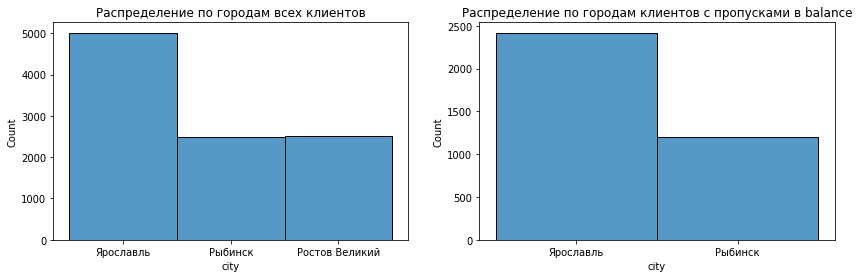

In [8]:
plt.subplots(figsize = (14, 4))
sns.histplot(df['city'], bins=3, ax = plt.subplot(1, 2, 1))
plt.title(f'Распределение по городам всех клиентов')
sns.histplot(df[df['balance'].isna()]['city'], bins=3, ax = plt.subplot(1, 2, 2))
plt.title(f'Распределение по городам клиентов с пропусками в balance')
plt.show()

Пропуски в колонке `balance` наблюдаются только у клиентов из Рыбинска и Ярославля, однако данная информация не поможет в обработке пропущенных значений

Подсчитаем количество клиентов с нулевым балансом на счёте

In [9]:
df[df['balance'] == 0]['userid'].count()

0

**Выводы:**
- Названия колонок приведены к нижнему регистру
- Дубликатов не найдено
- Присутствие многочисленных пропусков в колонке `balance` вероятно связано с отсутствием у клиента дебетового счета, в кредитной организации не могли потерять столь важную информацию

## Исследовательский анализ данных

### Более детально изучим датасет

In [10]:
df.drop(columns=['userid']).describe()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Никаких явных аномалий в данных не наблюдается

### Изучим средние значения в двух группах — тех, кто ушел в отток и тех, кто остался

In [11]:
df.drop(columns=['userid']).groupby('churn').mean()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,
0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


В среднем менее активные клиенты и клиенты старшего возраста более склонны к оттоку

### Построим гистограммы для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

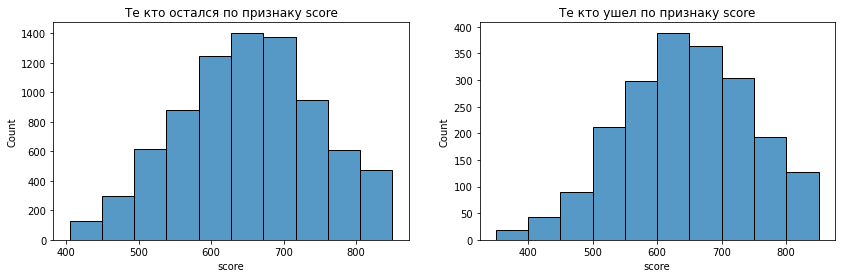

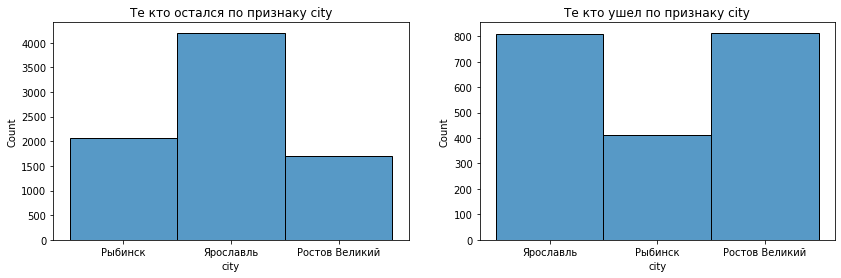

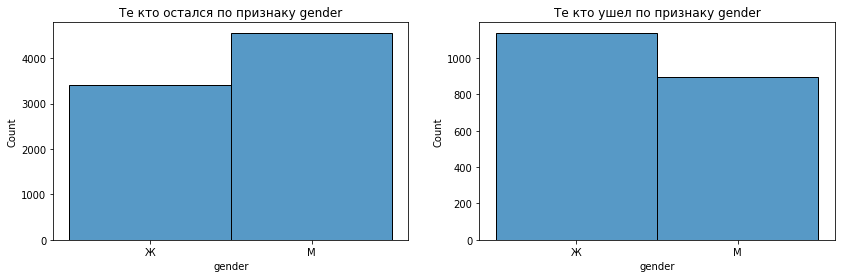

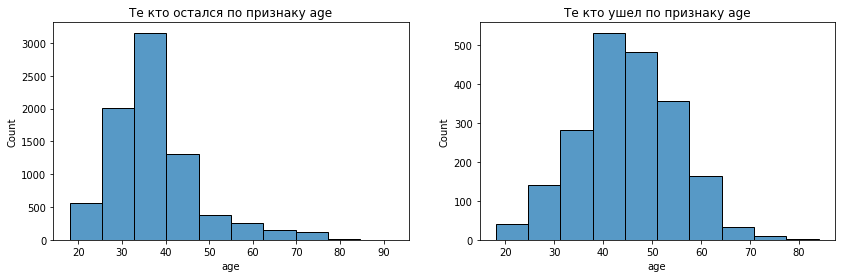

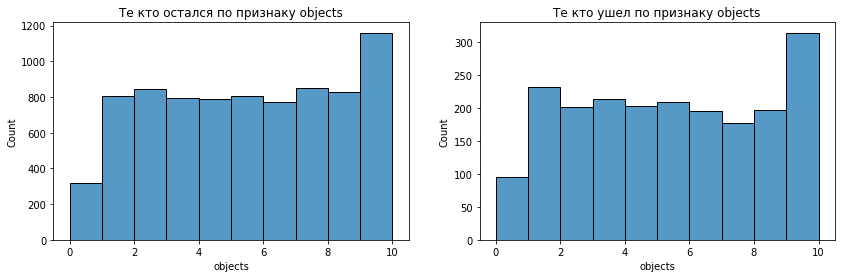

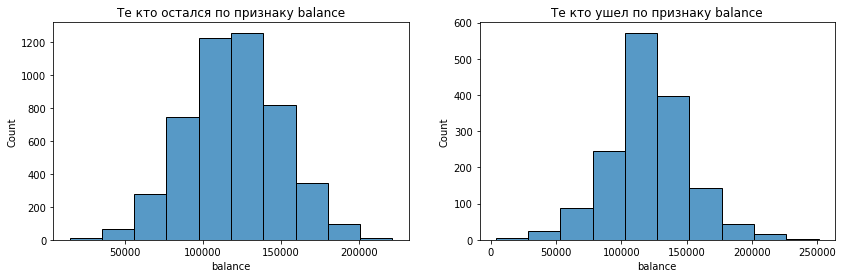

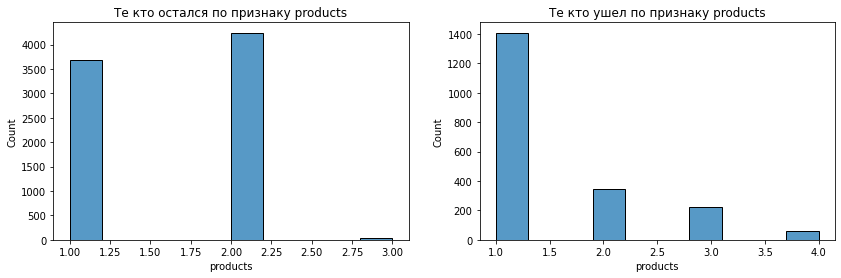

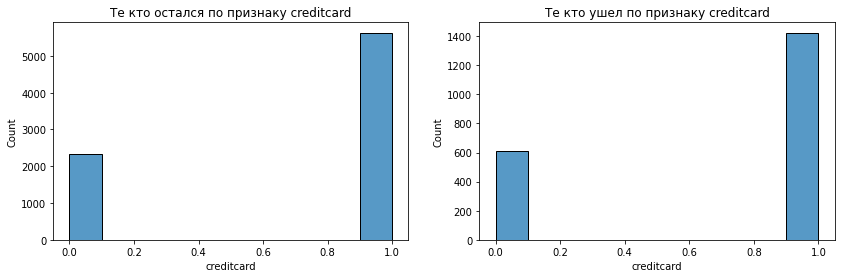

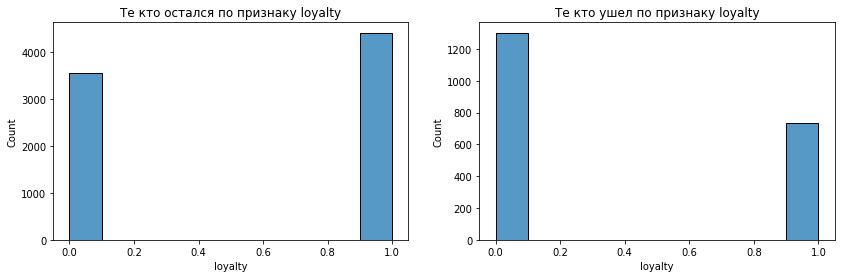

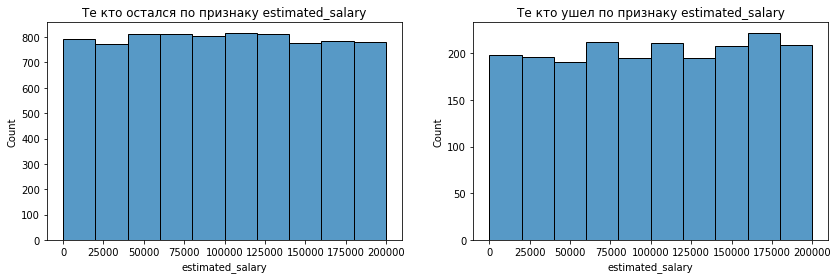

In [12]:
for feature in df.drop(columns=['userid', 'churn']):
    plt.subplots(figsize = (14, 4))
    sns.histplot(df.query('churn == 0')[feature], bins=10, ax = plt.subplot(1, 2, 1))
    plt.title(f'Те кто остался по признаку {feature}')
    sns.histplot(df.query('churn == 1')[feature], bins=10, ax = plt.subplot(1, 2, 2))
    plt.title(f'Те кто ушел по признаку {feature}')
    plt.show()

- Заметно больший отток, по сравнению с другими городами, наблюдается в городе Ростов Великий
- Клиенты женского пола более склонны к оттоку
- Ушедшие клиенты, в большинстве своем, пользовались всего 1 продуктом

### Построим матрицу корреляций

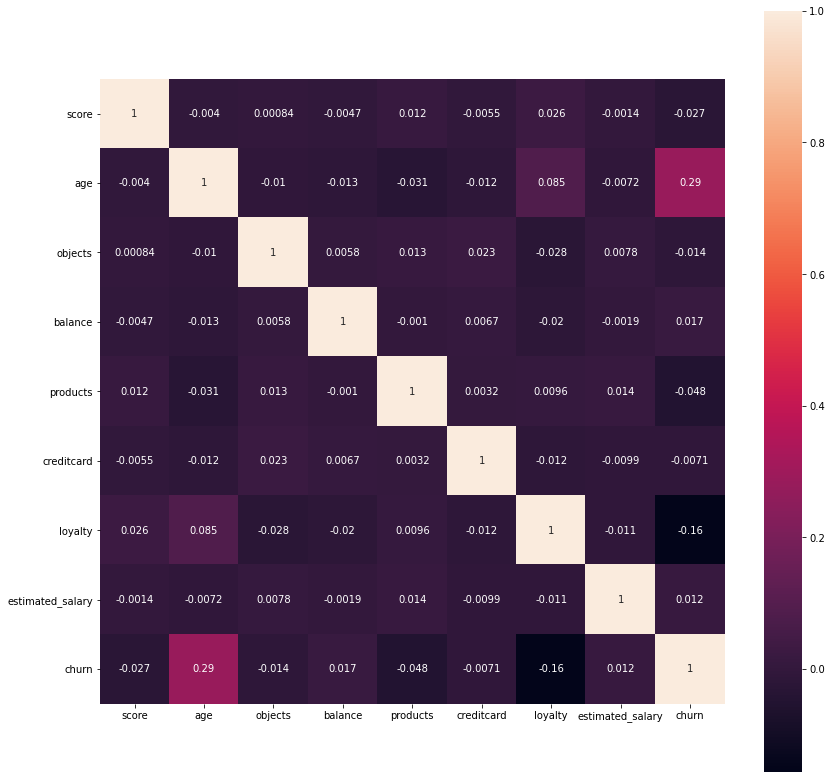

In [13]:
cm = df.drop(columns=['userid']).corr()

plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Можно заметить слабую корреляцию с целевой переменной `churn` у признаков `age` и `loyalty`

### Рассмотрим средние значения для каждого города

In [14]:
df.drop(columns=['userid']).groupby('city').mean()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
city,,,,,,,,,
Ростов Великий,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Рыбинск,651.333872,38.890997,5.032297,119814.985923,1.539362,0.694792,0.529673,99440.572281,0.166734
Ярославль,649.668329,38.511767,5.004587,119927.765597,1.530913,0.706621,0.516753,99899.180814,0.161548


В средних значениях разных городов не наблюдается значимых различий, но в городе Ростов Великий коэффициент оттока почти в 2 раза выше

## Формулировка и проверка статистических гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались

Так как в колонке с данными о заработной плате клиентов не обнаружено выбросов, для проверки гипотезы будет использован параметрический метод `st.ttest_ind()`

In [15]:
sample_1 = df.query('churn == 0')
sample_2 = df.query('churn == 1')

# Сравним дисперсии двух выборок
print(np.var(sample_1['estimated_salary'], ddof=1))
np.var(sample_2['estimated_salary'], ddof=1)

3295401414.9183965


3353848166.8070116

Разница меджу дисперсиями двух выброрк незначительна, Параметр equal_var будет выставлен по умолчанию

Проверим двустороннюю (ненаправленную) гипотезу. Если уровень значимости (p-value) окажется меньше критического уровеня в 0.05, гипотеза о равенстве двух выборок ($H_0$) будет отвегрнута

$H_0$ - Отсутствует статистически значимое различие в средних значениях двух выборок

$H_1$ - Различие в средних значениях между выбороками статистически значимо

In [16]:
alpha = 0.05
results = st.ttest_ind(sample_1['estimated_salary'],
sample_2['estimated_salary'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу


Различие в доходах между ушедшими и оставшимися клиентами не является статистически значимым

### Проверка гипотезы о разнице в возрасте между теми клиентами, которые ушли и теми, которые остались

In [17]:
# Сравним дисперсии двух выборок
print(np.var(sample_1['age'], ddof=1))
np.var(sample_2['age'], ddof=1)

102.52297408041709


95.28808400195597

Разница меджу дисперсиями двух выброрк незначительна, Параметр equal_var будет выставлен по умолчанию

Проверим двустороннюю (ненаправленную) гипотезу. Если уровень значимости (p-value) окажется меньше критического уровеня в 0.05, гипотеза о равенстве двух выборок ($H_0$) будет отвегрнута

$H_0$ - Отсутствует статистически значимое различие в средних значениях двух выборок

$H_1$ - Различие в средних значениях между выбороками статистически значимо

In [18]:
results = st.ttest_ind(sample_1['age'],
sample_2['age'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2399313093427738e-186
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, разнице в возрасте между ушедшими и оставшимися клиентами статистически значима

## Общие выводы

**Выводы:**
- Ушедшие клиенты, в большинстве своем, пользовались всего 1 продуктом
- Наиболее склонны к оттоку клиенты старшего возраста и неактивные клиенты
- Заметно больший отток, по сравнению с другими городами, наблюдается в городе Ростов Великий

**Рекомендации:**

Для увеличения коэффициента удержания клиентам старшего возраста можно предложить следующие продукты:
- Дебетовые карты системы «Мир» с кэшбэком на покупки в аптеках (получать пенсии и соц. выплаты в России можно только на карты системы «Мир»)
- Специальные банковские вклады для пенсионеров с более высокими, по сравнению с обычными, ставками, либо с другими полезными преференциями (более низкую минимальную сумму вклада или досрочное закрытие на льготных условиях)

Также можно попытаться сократить число неактивных клиентов предлагая им кредитные карты

В городе Ростов Великий следует провести проверку качества обслуживания клиентов банка

## Дополнительные материалы

[Ссылка на дашборд](https://public.tableau.com/views/_16495764149410/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

[Ссылка на презентацию](https://drive.google.com/file/d/13mOKGa99Ydgg_7ugcrRUQEm5IKkFLoB_/view?usp=sharing)